In [1]:
import os
import torch

from models import mlp, xaint
from data.utils import create_dataloaders_from_dataset_path, get_data_shape

dataset = os.path.join(os.getcwd(), "data", "dataset.csv")

train_loader, val_loader, test_loader = create_dataloaders_from_dataset_path(dataset)

input_size = get_data_shape(dataset)
hidden_sizes = [64, 128, 128, 128, 128, 128, 128]
output_size = 1

model_mlp = mlp.MLP(input_size=input_size, hidden_sizes=hidden_sizes, output_size=output_size)
model_mlp.load_state_dict(torch.load('checkpoints/mlp.pth', weights_only=True))

model_xaint = xaint.XAINT(model=model_mlp, k=4)

print(model_mlp, model_xaint, end="\n\n\n")

/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MLP(
  (hidden_layers): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
  )
) XAINT(
  (truncated_model): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in

In [2]:
mlp.test(model_mlp, test_loader)
model_xaint.test(test_loader)

Test Loss: 0.6700941291524143
Test Loss: 0.9904803032191788


In [3]:
from data.utils import get_val_samples

def shapExplain(model):
    import shap

    X_samples = get_val_samples(dataset, num_samples=64)
    explainer = shap.DeepExplainer(model, X_samples)
    shap_values = explainer.shap_values(X_samples)

    shap.initjs()
    
    import matplotlib.pyplot as plt
    import numpy as np

    def plot_shap_bar(shap_values, feature_names):
        shap_values = np.array(shap_values).squeeze()
        
        mean_abs_shap_values = np.mean(np.abs(shap_values), axis=0)
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(feature_names, mean_abs_shap_values, color='skyblue')
        plt.xlabel('Mean Absolute SHAP Value')
        plt.title('Feature Importance (SHAP)')
        
        for bar in bars:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                    f'{bar.get_width():.2f}', 
                    va='center')

        plt.show()

    plot_shap_bar(shap_values, feature_names=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'])



/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


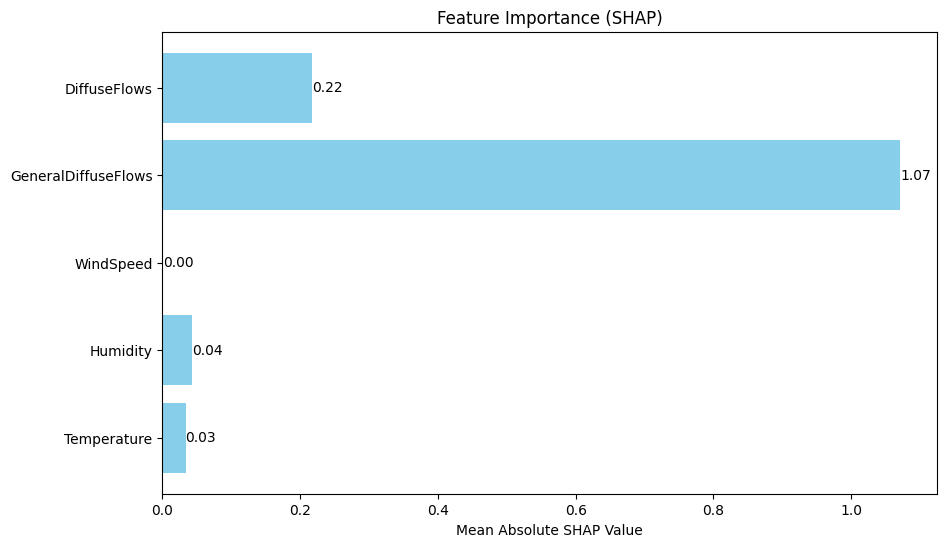

In [4]:
shapExplain(model_xaint)

Evaluating models:   0%|                                                   | 0/6 [00:00<?, ?model/s]

Test Loss: 0.9821136746464706


/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Evaluating models:  17%|#######1                                   | 1/6 [00:01<00:06,  1.38s/model]

Test Loss: 1.1792669259920352


/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Evaluating models:  33%|##############3                            | 2/6 [00:02<00:04,  1.19s/model]

Test Loss: 0.9863461721234206


/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Evaluating models:  50%|#####################5                     | 3/6 [00:03<00:03,  1.01s/model]

Test Loss: 0.9907372413975436


/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Evaluating models:  67%|############################6              | 4/6 [00:04<00:01,  1.06model/s]

Test Loss: 1.0154849072782004


/home/andrea-coppari/XAI/XAINT/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Evaluating models:  83%|###################################8       | 5/6 [00:04<00:00,  1.15model/s]

Test Loss: 1.1291500371767254


Evaluating models: 100%|###########################################| 6/6 [00:05<00:00,  1.10model/s]


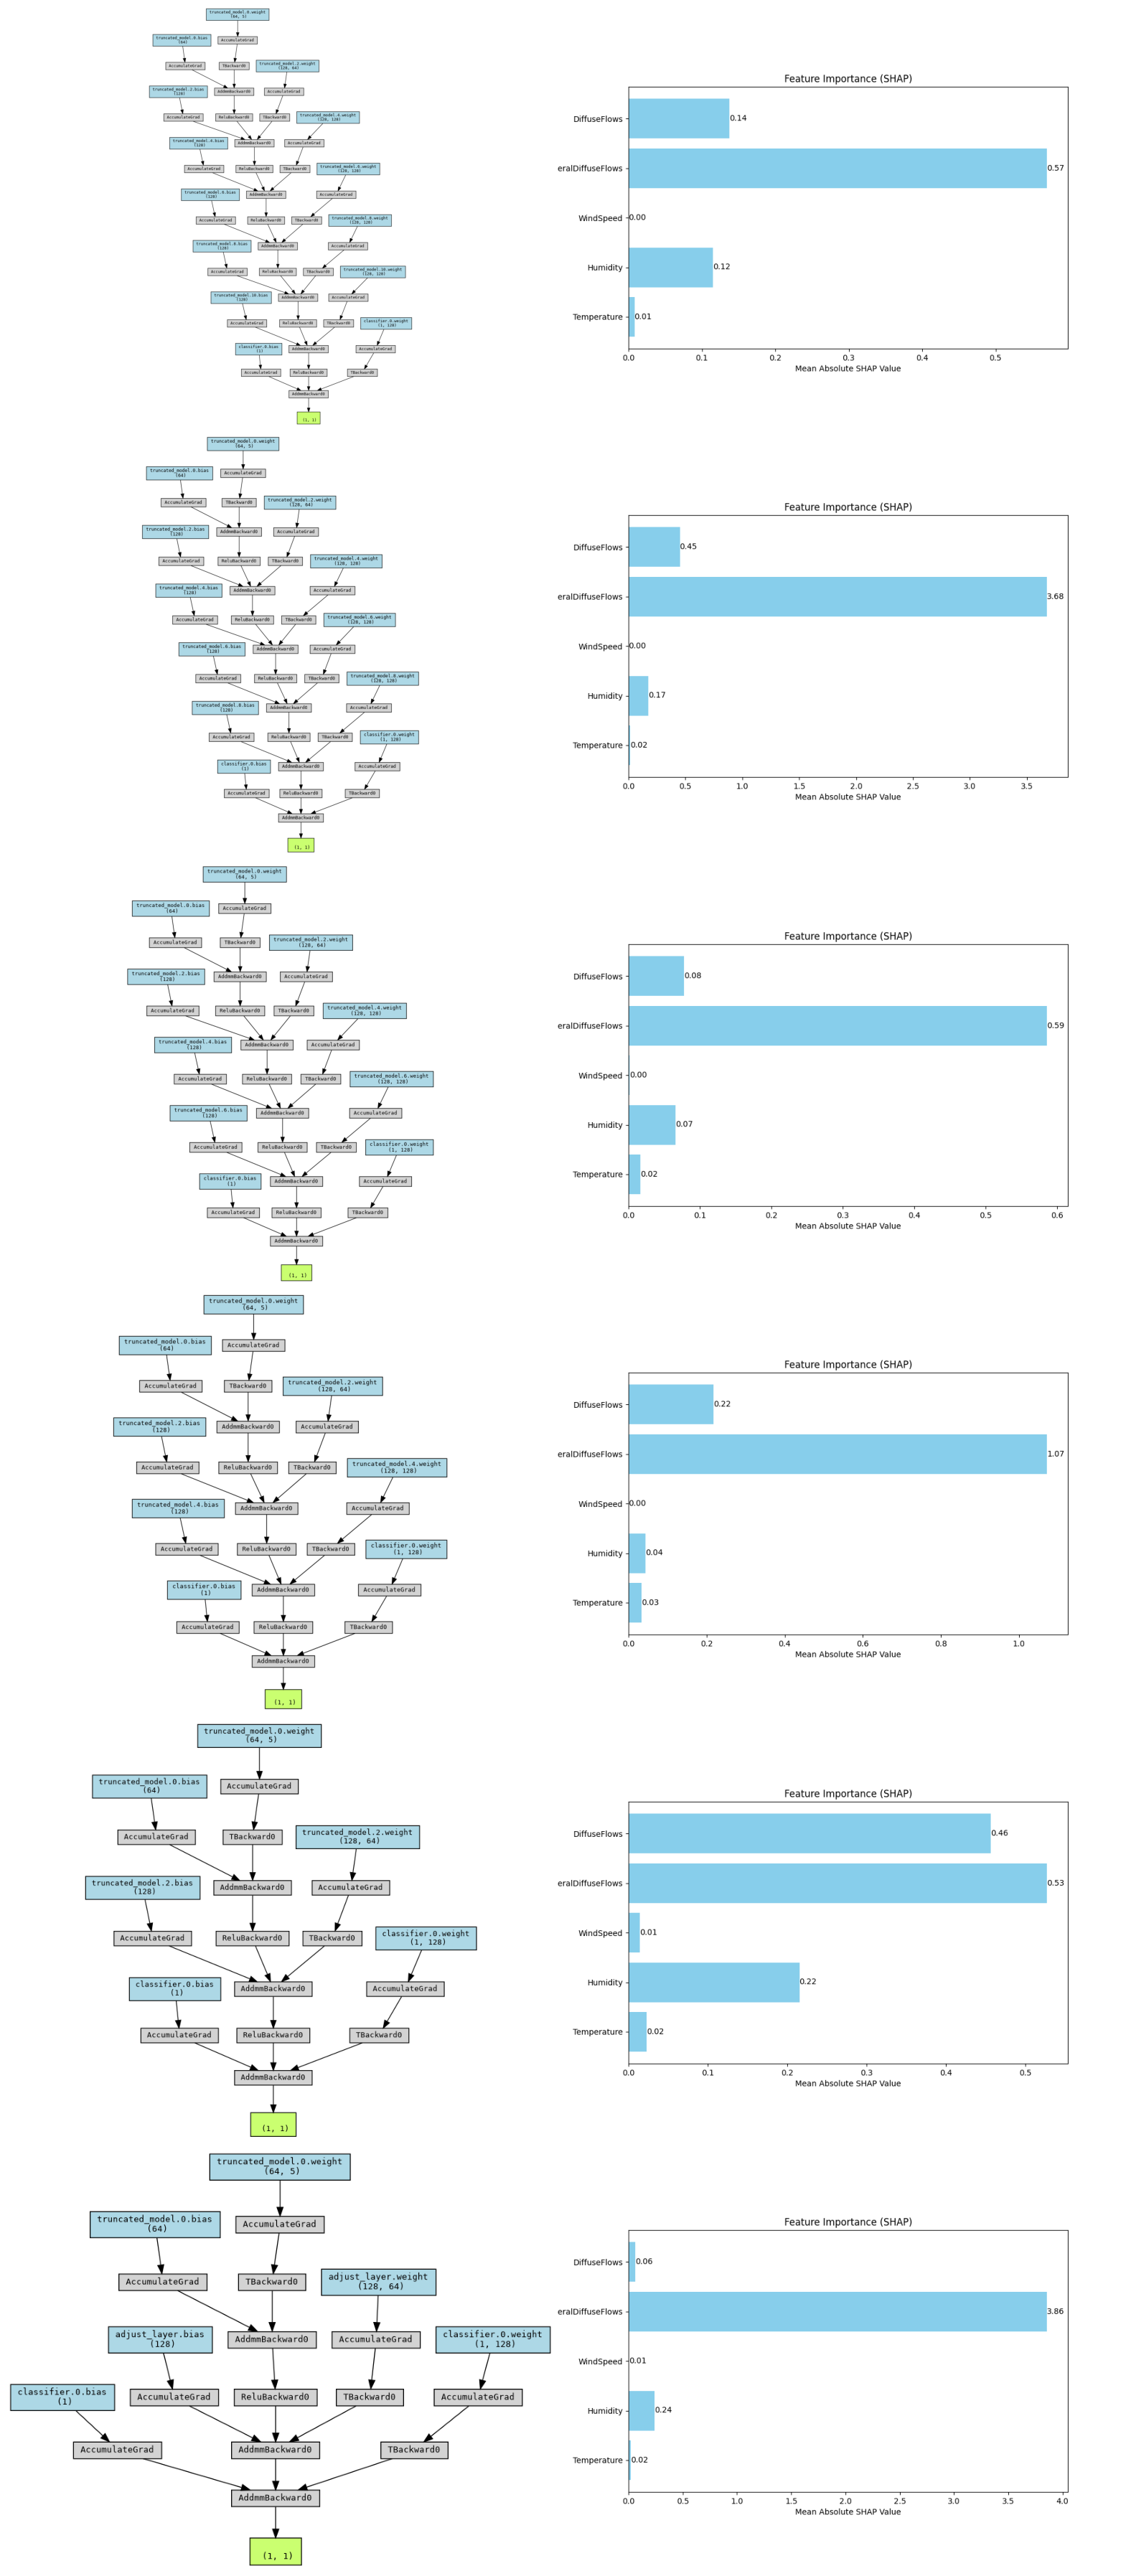

In [5]:
results = xaint.XAINT.iterate_k_and_evaluate(model=model_mlp, max_k=len(hidden_sizes)-1, test_loader=test_loader, dataset=dataset)